In [1]:
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.pyplot import scatter

#----------------------------------------------------------#

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

#----------------------------------------------------------#

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Preparing the Datasets
- Loading, Joining, Droping nulls and duplicates, 

In [2]:
seq = pd.read_csv('pdb_data_seq.csv', 
                  usecols = {'structureId','sequence'})
char = pd.read_csv('pdb_data_no_dups.csv', 
                   usecols = {'structureId','classification', 'macromoleculeType'})

df = char.set_index('structureId').join(seq.set_index('structureId'))
df = df.dropna()
df.drop_duplicates(subset='sequence')

,classification,macromoleculeType,sequence
structureId,,,
100D,DNA-RNA HYBRID,DNA/RNA Hybrid,CCGGCGCCGG
101D,DNA,DNA,CGCGAATTCGCG
101M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102D,DNA,DNA,CGCAAATTTGCG
102L,HYDROLASE(O-GLYCOSYL),Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
...,...,...,...
9MSI,ANTIFREEZE PROTEIN,Protein,ANQASVVANQLIPINTALNLVMMRSEVVTPVGIPAEDIPRLVSMQV...
9PAI,HYDROLASE INHIBITOR,Protein,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...
9PAI,HYDROLASE INHIBITOR,Protein,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP


In [3]:
#filtering only proteins
df = df[df.macromoleculeType == 'Protein'].drop(columns = {'macromoleculeType'})

#get the length of sequences and eleminate the too short, too long ones
df['resiude_count'] = df['sequence'].str.len()
df = df[df['resiude_count'] > 100 ]
df = df[df['resiude_count'] < 400]

- Lets take only the 5 most common classes

In [4]:
df = df.loc[df['classification'].isin( df['classification'].value_counts()[:6]
                                      .index.tolist())].reset_index()
df = df[df.classification != 'HYDROLASE/HYDROLASE INHIBITOR']

- Remove uncommon amino acids from each sequence (O, U, B, X, Z)

In [5]:
df['sequence']= df['sequence'].map(lambda x: re.sub('[*OUBXZ]', '', x))

HYDROLASE         31551
TRANSFERASE       26853
OXIDOREDUCTASE    21783
IMMUNE SYSTEM     11594
LYASE              8591
Name: classification, dtype: int64


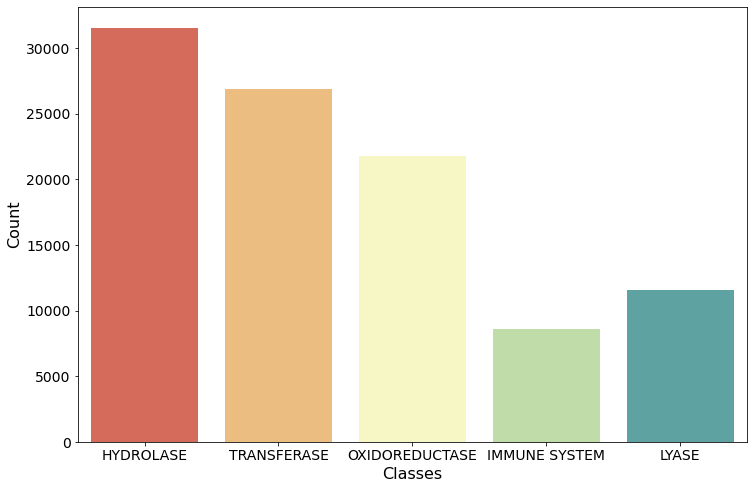

In [6]:
# Look at classification type counts
counts = df.classification.value_counts()
print(counts)

#plot counts
fig_dims = (12,8)
fig, ax = plt.subplots(figsize = fig_dims)
g = sns.countplot(df['classification'], ax = ax, palette = 'Spectral')
g.set_xticklabels(['HYDROLASE','TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNE SYSTEM', 'LYASE'], fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Classes',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.show()

In [7]:
#Experimenting with 10k rows
H = df[df.classification == 'HYDROLASE'].iloc[:2000]
R = df[df.classification == 'TRANSFERASE'].iloc[:2000]
O = df[df.classification == 'OXIDOREDUCTASE'].iloc[:2000]
I = df[df.classification == 'IMMUNE SYSTEM'].iloc[:2000]
L = df[df.classification == 'LYASE'].iloc[:2000]

frames = [H, R, O, I, L]
df1 = pd.concat(frames)
del H,R,O,I,L,frames
df1.to_csv('nlpdata.csv')

## Try Out the K-Means!

- ### Split Data

In [8]:
X_train, X_test,y_train,y_test = train_test_split(df1['sequence'], 
                                                  df1['classification'], 
                                                  test_size = 0.20, 
                                                  random_state = 7)

- ### Count verctorizer and standardize the matrix

In [9]:
cv = CountVectorizer(ngram_range = (4,4), lowercase = False,
                          analyzer = 'char', min_df = 0.01) 
#Have tried ngram_range = (1,1), (3,7) and (2,4)!! not the best results

In [10]:
x_cv = cv.fit_transform(X_train)
x = pd.DataFrame(x_cv.toarray(), columns=cv.get_feature_names())  
x = (x - x.mean()) / x.std()

- ###### Reduce dimensions with TruncatedSVD

In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=7)
svd_x = svd.fit(x)
#print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
svdfeatures = svd_x.transform(x)

0.5665477953302628


In [13]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 5, random_state = 7, max_iter = 100) 
km.fit(svdfeatures)

KMeans(max_iter=100, n_clusters=5, random_state=7)

In [14]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()

In [15]:
for i in range(5):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind])
terms

Cluster 0:
 AAAK
 AALA
 AALV
 AALR
 AAIA
Cluster 1:
 AAAA
 AAAG
 AAAH
 AAAL
 AAAS
Cluster 2:
 AAAG
 AAAR
 AAAH
 AAAL
 AAAM
Cluster 3:
 AAAM
 AAAH
 AAAL
 AAKA
 AAGV
Cluster 4:
 AAAG
 AAAH
 AAAL
 AAAS
 AAPT


['AAAA',
 'AAAG',
 'AAAH',
 'AAAK',
 'AAAL',
 'AAAM',
 'AAAR',
 'AAAS',
 'AAAT',
 'AAAV',
 'AADE',
 'AADL',
 'AADM',
 'AAEA',
 'AAEG',
 'AAEI',
 'AAEL',
 'AAGA',
 'AAGE',
 'AAGG',
 'AAGI',
 'AAGS',
 'AAGV',
 'AAGY',
 'AAHC',
 'AAIA',
 'AAKA',
 'AAKF',
 'AAKS',
 'AAKT',
 'AALA',
 'AALE',
 'AALG',
 'AALI',
 'AALK',
 'AALL',
 'AALP',
 'AALR',
 'AALT',
 'AALV',
 'AAMK',
 'AANN',
 'AAPS',
 'AAPT',
 'AAQA',
 'AAQE',
 'AAQI',
 'AAQL',
 'AAQT',
 'AARA',
 'AARI',
 'AASA',
 'AASG',
 'AASL',
 'AASP',
 'AASQ',
 'AASS',
 'AATG',
 'AAVA',
 'AAVD',
 'AAVE',
 'AAVG',
 'AAVL',
 'AAVN',
 'AAVR',
 'AAVV',
 'AAVY',
 'ACAK',
 'ACEV',
 'ACGV',
 'ACHL',
 'ADAA',
 'ADAI',
 'ADAL',
 'ADAV',
 'ADES',
 'ADFG',
 'ADFI',
 'ADFT',
 'ADGV',
 'ADIA',
 'ADIT',
 'ADKD',
 'ADLG',
 'ADLL',
 'ADLV',
 'ADMA',
 'ADSV',
 'ADVV',
 'ADYE',
 'AEAA',
 'AEAL',
 'AEAV',
 'AEDL',
 'AEEL',
 'AEEV',
 'AEIA',
 'AEIT',
 'AEKL',
 'AELA',
 'AELE',
 'AELH',
 'AELL',
 'AELV',
 'AENP',
 'AEQL',
 'AERL',
 'AETG',
 'AEVA',
 'AFAA',
 'AFGG',
 

- ###### Testing on the train data

In [ ]:
'''
cv = CountVectorizer(ngram_range = (1,1), lowercase = False,
                          analyzer = 'char', min_df = 0.01)
x_cv = cv.fit_transform(X_train)
x = pd.DataFrame(x_cv.toarray(), columns=cv.get_feature_names())  
x = (x - x.mean()) / x.std()
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=7)
svd_x = svd.fit(x)
#print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
svdfeatures = svd_x.transform(x)
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 5, random_state = 7, max_iter = 100) 
km.fit(svdfeatures)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind])
terms
'''

In [11]:
tt = y_train.reset_index()
rr = X_train.reset_index()
check = tt.set_index('index').join(rr.set_index('index'))
del tt, rr

temp = cv.transform(check['sequence'])
temp = svd.transform(temp)
check['predication'] = km.predict(temp)

In [12]:
results = (check.groupby(['classification']).agg(lambda x:x.mode()).reset_index())
print(results)

   classification                                           sequence  \
0       HYDROLASE  PSLSKEAALVHEALVARGLETPLRPPVHEMDNETRKSLIAGHMTEI...   
1   IMMUNE SYSTEM  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
2           LYASE  PRSLANAPIMILNGPNLNLLGQRQPEIYGSDTLADVEALCVKAAAA...   
3  OXIDOREDUCTASE  MAKLGIHSNDTRDAWVNKIAQLNTLEKAAEMLKQFRMDHTTPFRNS...   
4     TRANSFERASE  MKRKGIILAGGSGTRLHPATLAISKQLLPVYDKPMIYYPLSTLMLA...   

   predication  
0            1  
1            1  
2            1  
3            1  
4            1  


## Try out supervised learning? why not

In [18]:
#balancing the data and splitting
H = df[df.classification == 'HYDROLASE'].iloc[:8500]
R = df[df.classification == 'TRANSFERASE'].iloc[:8500]
O = df[df.classification == 'OXIDOREDUCTASE'].iloc[:8500]
I = df[df.classification == 'IMMUNE SYSTEM'].iloc[:8500]
L = df[df.classification == 'LYASE'].iloc[:8500]

frames = [H, R, O, I, L]
df2 = pd.concat(frames)
del H,R,O,I,L,frames

X_trains, X_tests ,y_trains ,y_tesst = train_test_split(df2['sequence'], 
                                                  df2['classification'], 
                                                  test_size = 0.20, 
                                                  random_state = 7)

- ##### Random Forest Model.
1- Training

In [19]:
cvs = CountVectorizer(ngram_range = (4,5), lowercase = False,
                          analyzer = 'char', min_df = 0.01, max_df = 0.97) 
x_cvt = cvs.fit_transform(X_trains)
xt = pd.DataFrame(x_cvt.toarray(), columns=cvs.get_feature_names())  
xt = (xt - xt.mean()) / xt.std()
xt.info()

pcat = PCA(n_components = 0.8)
pca_x = pcat.fit(xt)
pcafeatures = pca_x.transform(xt)

#print(pca_x.explained_variance_ratio_.sum())
#pcafeatures.shape

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 7, 
                            min_samples_leaf = 2, max_depth = 22, 
                            n_estimators = 200)
rf.fit(pcafeatures, y_trains)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34000 entries, 0 to 33999
Columns: 2989 entries, AAAA to YYNQS
dtypes: float64(2989)
memory usage: 775.3 MB
0.8001484556205556


RandomForestClassifier(max_depth=22, min_samples_leaf=2, n_estimators=200,
                       random_state=7)

2- Testing

In [20]:
from sklearn.metrics import accuracy_score, mean_squared_error

x_cvr = cvs.transform(X_tests)
xr = pd.DataFrame(x_cvr.toarray(), columns=cvs.get_feature_names())  
xr = (xr - xr.mean()) / xr.std()

pcafeaturesr = pca_x.transform(xr)

y_pred = rf.predict(pcafeaturesr)
print('RandomForest model Accuracy is: ', accuracy_score(y_tesst, y_pred))
#print(mean_squared_error(y_tesst, y_pred))

RandomForest model Accuracy is:  0.8874117647058823
